<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/MobNetV3_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

2025-03-12 15:16:48.801289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 15:16:48.869588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 15:16:48.897334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 15:16:49.102381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [4]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [5]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # bens hpc file path
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [6]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [7]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine labels and image file paths into one dataframe

In [8]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [9]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
1,0.4375,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,0.8125,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,0.5000,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


In [10]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) EDA

In [11]:
merged_df.value_counts('angle')

angle
0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: count, dtype: int64

note: imbalance datset

identifying the row with the erroneous speed value

In [12]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3884.png


we want to remove this row

In [13]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3882.png
3883,0.3750,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3883.png
3885,0.0000,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3885.png
3886,0.7500,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3886.png


### 1d) convert images to numerical RGB feature maps

In [14]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["angle"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2025-03-12 15:17:28.791117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7916 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2025-03-12 15:17:28.791905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9789 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


lets check and see if what we have done works

In [15]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)
    print(labels)

2025-03-12 15:17:39.201641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3127 of 13792


(32, 224, 224, 3) (32,)
tf.Tensor(
[0.3125 0.75   0.4375 0.3125 0.5625 0.75   0.5625 0.625  0.6875 0.6875
 0.6875 0.875  0.625  0.75   0.8125 0.6875 0.625  0.625  0.625  0.875
 0.25   0.5    0.625  0.6875 0.75   0.8125 0.5    0.6875 0.8125 0.375
 0.6875 0.375 ], shape=(32,), dtype=float64)


2025-03-12 15:17:49.004696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-12 15:17:49.012815: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [16]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

In [17]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 344, validation size: 87


In [18]:
validation_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### 1f) Data augmentation applied to training set

Flipping or rotating the image will render the angle labels incorrect so none of that was applied to the images for this regression task

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment


In [19]:
# #only performing augmentation on training data as want validation/test data to reflect kaggle test set
# seed = (6,9)
# train_dataset = train_dataset.map(
#       lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_contrast(image,0.8,1.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_hue(image,0.2,seed),label)
# ).map(
#       lambda image, label: (tf.image.stateless_random_saturation(image,0.8,1.2,seed),label)
# ).take(5
# )

In [20]:
# Define your augmentation function (same as before)
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

In [21]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

2025-03-12 15:17:53.490177: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of images in train_dataset: 22016


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.4375
image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.4375
image shape:  (224, 224, 3)
label: 0.625


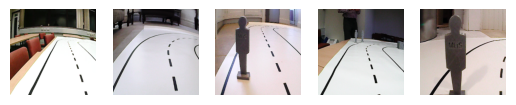

In [22]:
f, axarr = plt.subplots(1,5)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 5:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building - MobileNetV3Large Transfer Learning

a) Set up model architecture

b) define training step

c) training the model on the training set

d) fine-tuning

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

### 2b) Define training step

- adam optimiser
- binary cross entropy loss function

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

### 2c) Training the model on the training set

In [ ]:
niter = 200

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

2025-03-12 13:52:18.798174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1741787540.095040 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.280704 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.281517 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.282321 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.362959 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.387725 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.388785 3126024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741787540.390169 3126024 gpu_

iter: 0, train_loss: 0.011, train_MSE: 0.039, val_loss: 0.010, val_MSE: 0.041


2025-03-12 13:53:41.135810: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 13:55:36.078424: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 10, train_loss: 0.007, train_MSE: 0.041, val_loss: 0.007, val_MSE: 0.041


2025-03-12 13:58:46.834606: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 20, train_loss: 0.006, train_MSE: 0.041, val_loss: 0.006, val_MSE: 0.044


2025-03-12 14:04:32.199354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 30, train_loss: 0.006, train_MSE: 0.042, val_loss: 0.006, val_MSE: 0.043


In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [23]:
dropoutrate = 0.2
num_classes = 1
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = True # UNFREEZE mbnet layers

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 3,261,233 (12.44 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [24]:
model.load_weights('/home/apyba3/car_frozen_regression.weights.h5')

Set up fine-tuning training

In [25]:
LR = 0.0001 #deliberately smaller learning rate for fine tuning
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

In [26]:
niter = 50

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

2025-03-12 15:18:54.995780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1741792735.060133 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.128913 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.129755 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.130431 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.145706 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.149157 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.149949 3150847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741792735.150768 3150847 gpu_

iter: 0, train_loss: 0.009, train_MSE: 0.039, val_loss: 0.008, val_MSE: 0.041


2025-03-12 15:21:27.148888: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 15:25:07.776265: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 10, train_loss: 0.005, train_MSE: 0.042, val_loss: 0.005, val_MSE: 0.042


2025-03-12 15:32:30.164475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 20, train_loss: 0.004, train_MSE: 0.043, val_loss: 0.003, val_MSE: 0.047


2025-03-12 15:47:12.281982: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 30, train_loss: 0.004, train_MSE: 0.043, val_loss: 0.003, val_MSE: 0.044
iter: 40, train_loss: 0.001, train_MSE: 0.047, val_loss: 0.001, val_MSE: 0.047


In [27]:
model.save_weights('/home/apyba3/car_unfrozen_regression.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [28]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [29]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [30]:
predictions = model.predict(test_dataset)

I0000 00:00:1741795536.978495 3150849 service.cc:146] XLA service 0x7f78bc06efd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741795536.978712 3150849 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1741795536.978729 3150849 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-12 16:05:37.440397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3:36 7s/step

I0000 00:00:1741795542.328537 3150849 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [31]:
predictions_df = pd.DataFrame(predictions, columns=['angle'])

In [32]:
predictions_df.head()

,angle
0,0.551765
1,0.741088
2,0.224388
3,0.153104
4,0.171934


In [33]:
predictions_df['angle'].value_counts()

angle
 0.163171    1
 0.551765    1
 0.741088    1
 0.224388    1
 0.153104    1
 0.171934    1
 0.732616    1
 0.638916    1
 0.838423    1
 0.567392    1
 0.677574    1
 0.499045    1
 0.711091    1
 0.495304    1
 0.576120    1
 0.294072    1
 0.675287    1
 0.533935    1
 0.744491    1
 0.427530    1
 0.108543    1
 0.928770    1
 0.117964    1
 0.292919    1
 0.742702    1
 0.715883    1
 0.735856    1
 0.604007    1
 0.750887    1
 0.567873    1
 0.658652    1
 0.679296    1
 0.699717    1
 0.144953    1
 0.508170    1
 0.645463    1
 0.577817    1
 0.473270    1
 0.632438    1
 0.617522    1
 0.230228    1
 0.798455    1
 0.753164    1
 0.796748    1
 0.616715    1
 0.418673    1
 0.666741    1
 0.499980    1
 0.654059    1
 0.328249    1
 0.821813    1
 0.504648    1
 0.614886    1
 0.101510    1
 0.124554    1
 0.066374    1
 0.490511    1
 0.287771    1
 0.639881    1
 0.489903    1
 0.460812    1
 0.441937    1
 0.532672    1
 0.181401    1
 0.578612    1
 0.291568    1
 0.4

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [34]:
predictions_df.to_csv('/home/apyba3/mbnetv3_angleregression_predictions.csv')